# Classification with FACET

***

**Robust and impactful Data Science with FACET**

FACET enables us to perform a number of critical steps in best practice Data Science work flow easily, efficiently and reproducibly:

1. Create a robust pipeline for learner selection using LearnerRanker and enabling the use of bootstrap cross-validation.

2. Enhance our model inspection to understand drivers of predictions using local explanations of features via [SHAP values](http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions) by applying a novel methodology that decomposes SHAP values into measures of synergy, redundancy, and independence between each pair of features.

3. Quickly apply historical simulation to gain key insights into feature values that minimize or maximize the predicted outcome.

***

**Context**

With the advaced capabilities FACET provides by extending SHAP-based model inspection, it is important to gain some intution for how the newly introduced measures for feature redundancy and synergy can vary. As SHAP values represent post-processing after data preparation, feature engineering, preprocessing and model selection/tuning, minimal simulation studies offer a way to make the connection as direct as possible.

In this FACET tutorial we will conduct two simulation studies to gain intuition about synergy and redundancy:

- explore patterns in synergy and redundancy as a function of the individual and joint contribution of two continuous features in predicting a binary target where the features have varying degrees of correlation.
- explore synergy and redundancy as a function of regularization of a random forest by varying the `max_depth` parameter.

***

**Tutorial outline**

1. [Redundancy and Synergy](#Redundancy-and-Synergy)
2. [Data simulation](#Data-simulation)
3. [How redundancy and synergy change with feature correlation and interaction](#How-redundancy-and-synergy-change-with-feature-correlation-and-interaction)
4. [How overfitting affects the accuracy of redundancy and synergy estimates](#How-overfitting-affects-the-accuracy-of-redundancy-and-synergy-estimates)
5. [Summary](#Summary)
6. [What can you do next?](#What-can-you-do-next?)
7. [Appendix](#Appendix)

In [3]:
# this cell's metadata contains
# "nbsphinx": "hidden" so it is hidden by nbsphinx

def _set_paths() -> None:
    # set the correct path when launched from within PyCharm

    module_paths = ["pytools", "facet", "sklearndf"]

    import sys
    import os
    
    if 'cwd' not in globals():
        # noinspection PyGlobalUndefined
        global cwd
        cwd = os.path.join(os.getcwd(), os.pardir, os.pardir, os.pardir)
        os.chdir(cwd)   
    print(f"working dir is '{os.getcwd()}'")
    for module_path in module_paths:
        if module_path not in sys.path:
            sys.path.insert(0, os.path.abspath(f"{cwd}/{os.pardir}/{module_path}/src"))
        print(f"added `{sys.path[0]}` to python paths")
        
def _ignore_warnings():
    # ignore irrelevant warnings that would affect the output of this tutorial notebook
    
    # ignore a useless LGBM warning
    import warnings
    warnings.filterwarnings("ignore", category=UserWarning, message=r".*Xcode_8\.3\.3")

_set_paths()
_ignore_warnings()

del _set_paths, _ignore_warnings

working dir is '/mnt/c/projects/facet/facet'
added `/mnt/c/projects/facet/pytools/src` to python paths
added `/mnt/c/projects/facet/facet/src` to python paths
added `/mnt/c/projects/facet/sklearndf/src` to python paths


In [4]:
# standard imports
import numpy as np
import pandas as pd
from scipy.linalg import toeplitz
import matplotlib.pyplot as plt
import shap
import itertools
import seaborn as sns
from sklearn.model_selection import RepeatedKFold

# FACET imports
from facet import Sample
from facet.crossfit import LearnerCrossfit
from facet.inspection import LearnerInspector
from facet.selection import LearnerRanker, LearnerGrid
from facet.validation import BootstrapCV

# sklearndf imports
from sklearndf.pipeline import PipelineDF, ClassifierPipelineDF
from sklearndf.classification import RandomForestClassifierDF

In [5]:
# this cell's metadata contains
# "nbsphinx": "hidden" so it is hidden by nbsphinx

def _configure_matplotlib():
    # set global options for matplotlib
    
    import matplotlib
    
    matplotlib.rcParams['figure.figsize'] = (16.0, 8.0)
    matplotlib.rcParams['figure.dpi'] = 72

_configure_matplotlib()

del _configure_matplotlib

# Redundancy, Synergy and SHAP

Redundancy and synergy are part of the key extensions FACET makes to using SHAP values to understand model predictions. 

The [SHAP approach](http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions) has become the standard method for model inspection. SHAP values are used to explain the additive contribution of each feature to the prediction for a given observation. SHAP values are computed for every feature and observation.

The FACET `LearnerInspector` computes SHAP values for each crossfit (i.e., a CV fold or bootstrap resample) using the best model identified by the `LearnerRanker`. The FACET `LearnerInspector` then provides advanced model inspection through new SHAP-based summary metrics for understanding feature redundancy and synergy.

The definitions are as follows:

1. **Redundancy** represents how much information is shared between two features contributions to model predictions. In our example we might expect redundancy between BMI and waist circumference as a higher BMI will tend to lead to a larger waist circumference and vice versa. This means just knowing one or the other is likely to provide similar predictive performance.


2. **Synergy** represents how much the combined information of two features contributes to the model predictions. In our example we could hypothesize that knowing both gender and BMI provides greater accuracy in predicting prediabetes risk than either alone.

In breif, redundancy represents the shared information between two features and synergy represents the degree to which one feature combines with another to generate a prediction. It is also important to recognize:

- that any pair of features may have both redundancy and synergy
- that SHAP values are dependent upon the model, so under- or over-fitting will influence redundancy and synergy

# Data simulation

For the simulation studies we generate data as follows:

$$ (X_1, X_2) \sim N\left[\left(\begin{array}{c} 0\\0 \end{array}\right), \left(\begin{array}{cc} 1 & \rho\\ \rho & 1 \end{array}\right)\right]$$
   
    
$$p = \cfrac{1}{1 + exp(-[\beta_0 + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_1 X_2])}$$
    
    
$$U \sim \textrm{U}(0,1)$$
    
    
$$y = \begin{cases}
1 & U < p  \\
0 & U \geq p
\end{cases}$$

Importantly we use the correlation ($\rho$) between features as a way to induce redundancy, and the balance between an interaction ($\beta_3$) and main effects ($\beta_1, \beta_2$) to induce synergy. So for example, as the correlation gets higher we expect higher redundancy, and as the interaction gets stronger and the main effects get weaker, we expect higher synergy.

The function used to simulate data accoring to the above specifications is `sim_interaction()` and can be found in the [Appendix](#Data-simulation-code).

# How redundancy and synergy change with feature correlation and interaction

For this first simulation case study, we use the following parameters for data generation:

- intercept ($\beta_0$) = `[0]`
- main effects ($\beta_1, \beta_2$) = `[0, 1, 2, 3]`
- interaction ($\beta_3$) = `[1, 2, 3]`
- correlation ($\rho$) = `[0, 0.2, 0.4, 0.6, 0.8]`

For each combination of parameters above we simulate 20 datasets with 2000 observations. Model fitting is performed using 10 replicates of Bootstrap CV. The classifier used is a Random Forest with default hyper-parameters.

The code used to generate the data presented is shown in the [Appendix](#Simulation-study-1-code). You can experiment with the code and perform your own simulation studies, just be aware that it may take some time to run.

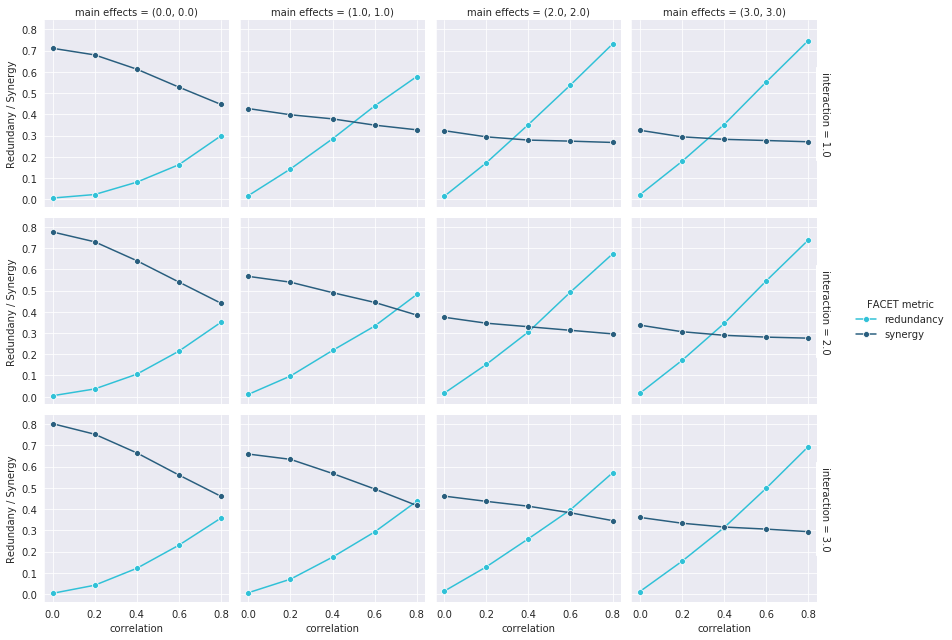

In [11]:
# load simulation study data
sns.set_style("darkgrid")
sim_data = pd.read_csv('sphinx/source/tutorial/classification_sim1.csv').set_index(['main effects', 'interaction', 'correlation'])
long_sim = sim_data[['redundancy', 'synergy']].stack().reset_index()
long_sim.rename(columns={'level_3':'FACET metric', 0:'Redundany / Synergy'}, inplace=True)

# create summary plot
sns.set_palette(["#30c1d7", "#295e7e"])
g = sns.FacetGrid(long_sim, col="main effects", row="interaction", hue='FACET metric', margin_titles=True)
g.map(sns.lineplot, "correlation", "Redundany / Synergy", estimator='mean', marker="o", ci=None)
g.add_legend()

There are several interesting patterns we can observe from the plot:

1. In general the larger the interaction the higher the synergy.
2. The greater the individual contributions of the features the lower the synergy.
3. As the correlation increases they redundancy increases and the synergy reduces.
4. Redundancy increases with increasing individual contributions of the features.

# How overfitting affects the accuracy of redundancy and synergy estimates

In this second simulation study we are going to explore the values of Synergy and Redundancy as a function of regularization in a random forest. The main regularization parameter is the `max_depth`, which controls the tree depth. In general, the deeper the tree the more likely we are to overfit the data. Because we will apply cross-validation we can get a sense of how model performance improves and then degrades with `max_depth` using the cross-validation curve.

For this second simulation case study, we use the following parameters for data generation:

- intercept ($\beta_0$) = `[0]`
- main effects ($\beta_1, \beta_2$) = `[1]`
- interaction ($\beta_3$) = `[3]`
- correlation ($\rho$) = `[0.5]`

We simulate 20 datasets with 1000 observations. The classifier used is a Random Forest with default hyper-parameters, except as follows:

- `max_depth = [2, 4, 8, 16, 32]`
- `n_estimators = [250]`

For each combination of parameters above we perform model fitting using 10 replicates of Bootstrap CV for each of the 20 simulated datasets.

The code used to generate the data presented is shown in the [Appendix](#Simulation-study-2-code). You can experiment with that code and perform your own simulation studies.

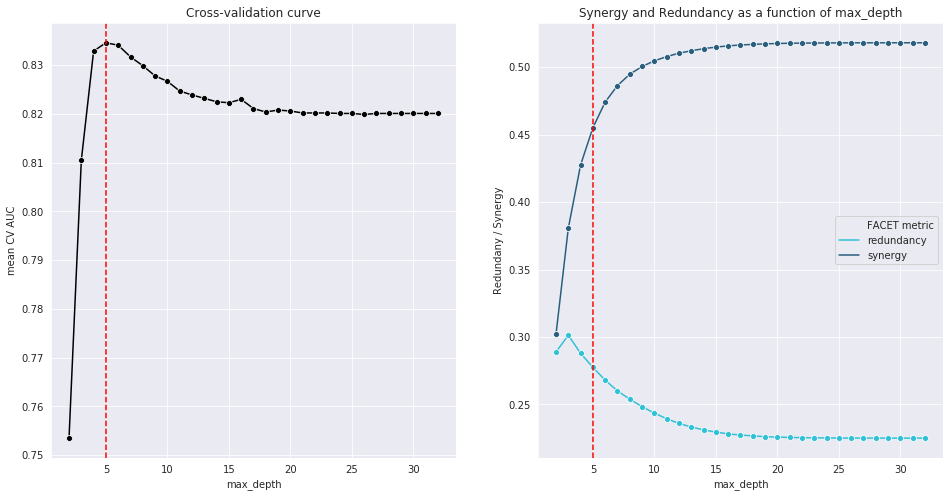

In [8]:
# plot simple cross-validation curve from Learner Ranker
AUC = [0.7535, 0.8105, 0.8329, 0.8346, 0.8341, 0.8317, 0.8299, 0.8278, 0.8267, 0.8247, 0.8239, 0.8232, 0.8225,
       0.8223, 0.8230, 0.8211, 0.8204, 0.8208, 0.8206, 0.8202, 0.8202, 0.8202, 0.8201, 0.8201, 0.8199, 0.8201, 
       0.8201, 0.8201, 0.8201, 0.8201, 0.8201]

plt.subplot(1, 2, 1)
ax = sns.lineplot(list(np.arange(2,33)), AUC, marker="o", color="black")
ax.set(xlabel='max_depth', ylabel='mean CV AUC', title='Cross-validation curve')
ax.axvline(5, color="red", linestyle="--")

# load simulation study data
sns.set_style("darkgrid")
sim_data = pd.read_csv('sphinx/source/tutorial/classification_sim2.csv').set_index(['max_depth', 'n_estimators'])
long_sim = sim_data[['redundancy', 'synergy']].stack().reset_index()
long_sim.rename(columns={'level_2':'FACET metric', 0:'Redundany / Synergy'}, inplace=True)

# create summary plot
plt.subplot(1, 2, 2)
sns.set_palette(["#30c1d7", "#295e7e"])
ax = sns.lineplot("max_depth", "Redundany / Synergy", data=long_sim, hue='FACET metric', estimator='mean', marker="o", ci=None)
ax.set(title='Synergy and Redundancy as a function of max_depth')
ax.axvline(5, color="red", linestyle="--")

We can observe the following from the figure above:

1. Based on the cross-validation curve, the best choice of `max_depth` is 5.
2. The value of synergy at the best `max_depth` of 5 is around 45% which is lower than the largest estimate of 52% when we overfit (right of `max_depth` = 5), and much greater than the smallest estimate of 30% when we underfit (left of `max_depth` = 5).
3. The value of redundancy at the best `max_depth` of 5 is around 28% which is higher than the smallest estimate of 23% when we overfit (right of `max_depth` = 5), and lower than the highest estimate of 30% when we underfit (left of `max_depth` = 5).

This suggests for a pair of moderately correlated features with a moderate interaction and limited individual contributions, overfitting might cause us to over-estimate synergy (i.e., the models sees noise as an interaction) and under-estimate redundnancy, while underfitting can cuase the opposite. As with all machine learning, identifying a well-tuned model is critical to obtaining apprporiate estimates of synergy and redundancy.

# Summary

We conducted two simulation studies using a simple controlled setting where we knew the amount of correlation, individual and combined contributions to a binary target.

- In the first simulation study we saw that the amount of correlation between two features as well as the strength of interaction and degree of independent contributions drives the balance between synergy and redudnacy. 
- In the second simulation study we saw how both synergy and redundancy changed as a function of the `max_depth` parameter of our Random Forest classifier. In particular, for a pari of features with correlation and interaction, how as `max_depth` increased synery increased and redundancy decreased.

# What can you do next?

There are a number of next steps that could be taken to gain further intuition regarding the capabilities of FACET:
    
1. Explore further values of main-effects, interactions and correlation between the two features used in the simulation studies.
2. Add further features to the simulation and explore what happends when you have features that are correlated but only one contributes to prediction (i.e., a purely redundant feature).
3. Try different learners and hyper-parameters and see how the redundancy and synergy results change. Remember, the contributions of features to individual predictions is through the "eyes" of the model.

# Appendix

## Data simulation code

```
def sim_interaction(
    n: int = 1000,
    intercept: float = None,
    coef_1: float = None,
    coef_2: float = None,
    coef_3: float = None,
    corr: float = 0
):

    # two standard normal features for interaction term in the linear predictor
    # mean and standard deviation of each feature
    mu = [0, 0]
    sd_mat = [1, 1]
    
    # correlation matrix
    corr_mat = np.array([[1, corr], [corr, 1]])

    # mean and standard deviation of each feature
    mu = [0, 0]
    sd_mat = [1, 1]

    # calculate covariance
    cov_mat = sd_mat*corr_mat*sd_mat
    
    tmp_data = pd.DataFrame(
        np.random.multivariate_normal(mu, cov_mat, size=n),
        columns=["feature_1", "feature_2"],
    )

    # linear predictor
    lp = (
        intercept
        + coef_1 * tmp_data.feature_1
        + coef_2 * tmp_data.feature_2
        + coef_3 * tmp_data.feature_1 * tmp_data.feature_2
    )

    # convert to probability
    prob = 1 / (1 + np.exp(-lp))

    # create target
    tmp_data["target"] = np.where(prob <= np.random.uniform(size=n), 0, 1)

    return tmp_data
```

## Simulation study 1 code

```
# conditions to iterate over
main_effects = [0, 1, 2, 3]
interaction = [1, 2, 3]
corr = [0, 0.2, 0.4, 0.6, 0.8]
conditions = list(itertools.product(*[main_effects, interaction, corr]))
n_sims = 20
n_conditions = len(conditions)
full_results = pd.DataFrame([])

# iterate over conditions
for i in range(n_conditions):
    
    print(i)
    
    # number of iterations for a set of conditions
    for j in range(n_sims):
        
        print(j)
        
        # simulate data
        sim_df = sim_interaction(intercept=0,
                                 n=2000,
                                 coef_1=conditions[i][0],
                                 coef_2=conditions[i][0],
                                 coef_3=conditions[i][1],
                                 corr=conditions[i][2])
        
        # run crossfit
        crossfit = LearnerCrossfit(
            pipeline=ClassifierPipelineDF(classifier=RandomForestClassifierDF(random_state=42)),
            cv=RepeatedKFold(n_splits=5, n_repeats=10, random_state=42),
            n_jobs=-1,
        ).fit(sample = Sample(
            observations=sim_df,
            features=['feature_1', 'feature_2'],
            target='target'
        ))

        # do a straight crossfit with fit inspector
        inspector = LearnerInspector(n_jobs=-1).fit(crossfit=crossfit)

        # obtain synergy and redundancy
        redundancy_matrix = inspector.feature_redundancy_matrix()
        synergy_matrix = inspector.feature_synergy_matrix()
        
        # assemble results
        tmp_results = pd.Series({'coef_1': conditions[i][0],
                   'coef_2': conditions[i][0],
                   'interaction': conditions[i][1],
                   'correlation': conditions[i][2],
                   'redundancy': redundancy_matrix.loc['feature_1', 'feature_2'],
                   'synergy': synergy_matrix.loc['feature_1', 'feature_2'],
                   'y_mean': sim_df.target.mean()})
        
        full_results = full_results.append(tmp_results, ignore_index=True)
        
full_results['main effects'] = "(" + full_results['coef_1'].astype(str) + ", " + full_results['coef_2'].astype(str) + ")"

# output to a csv file - and use in generating notebook
full_results.to_csv('sphinx/source/tutorial/classification_sim1.csv', index=False)
```

## Simulation study 2 code

First create a validation curve for `max_depth`.

```
# hyper-parameters to investigate
max_depth = list(np.arange(2,33))
n_estimators = [250]

# simulate train data
sim_df = sim_interaction(n=1000,
                         intercept=0,
                         coef_1=1,
                         coef_2=1,
                         coef_3=3,
                         corr=0.5)

# create classifier with required hyper-parameters
rf_pipeline=ClassifierPipelineDF(
    classifier=RandomForestClassifierDF(random_state=42)
)
rf_grid=LearnerGrid(
    pipeline=rf_pipeline,
    learner_parameters={'max_depth': max_depth,
                        'n_estimators': n_estimators}
)

# use learner ranker to assess hyper-parameters to create a validation curve for max_depth
ranker=LearnerRanker(
    grids=[rf_grid],
    cv=RepeatedKFold(n_splits=5, n_repeats=10, random_state=42),
    n_jobs=-3,
    scoring='roc_auc'
).fit(sample = Sample(
    observations=sim_df,
    features=['feature_1', 'feature_2'],
    target='target')
)

# used as source of values for plot
print(ranker.summary_report())
```

Next we run a simulation to assess the change in synergy and redundancy.

```
# hyper-parameters to investigate
max_depth = list(np.arange(2,33))
n_estimators = [250]

parm_grid = list(itertools.product(*[max_depth, n_estimators]))
n_sims = 20
n_parms = len(parm_grid)
full_results = pd.DataFrame([])

# number of iterations for a set of conditions
for j in range(n_sims):
    
    print(j)
        
    # simulate train data
    sim_df = sim_interaction(n=1000,
                             intercept=0,
                             coef_1=1,
                             coef_2=1,
                             coef_3=3,
                             corr=0.5)
    
    # iterate over hyper-parameters
    for i in range(n_parms):
        
        print(i)
        
        # create classifier with required hyper-parameters
        clf = ClassifierPipelineDF(
            classifier=RandomForestClassifierDF(
                random_state=42,
                max_depth=parm_grid[i][0],
                n_estimators=parm_grid[i][1]
            )
        )
        
        # run crossfit
        crossfit = LearnerCrossfit(
            pipeline=clf,
            cv=RepeatedKFold(n_splits=5, n_repeats=10, random_state=42),
            n_jobs=-1,
        ).fit(sample = Sample(
            observations=sim_df,
            features=['feature_1', 'feature_2'],
            target='target'
        ))

        # do a straight crossfit with fit inspector
        inspector = LearnerInspector(n_jobs=-1).fit(crossfit=crossfit)

        # obtain synergy and redundancy
        redundancy_matrix = inspector.feature_redundancy_matrix()
        synergy_matrix = inspector.feature_synergy_matrix()
        
        # assemble results
        tmp_results = pd.Series({'max_depth': parm_grid[i][0],
                   'n_estimators': parm_grid[i][1],
                   'redundancy': redundancy_matrix.loc['feature_1', 'feature_2'],
                   'synergy': synergy_matrix.loc['feature_1', 'feature_2'],
                   'y_mean': sim_df.target.mean()})
        
        full_results = full_results.append(tmp_results, ignore_index=True)
        
# output to a csv file - and use in generating notebook
full_results.to_csv('sphinx/source/tutorial/classification_sim2.csv', index=False)
```